In [1]:
import pandas as pd
import numpy as np
import os
import json
from matplotlib import pyplot as plt

In [2]:
tmpl_dirpath = "../outputs/{major}_{kind_of_qa}_{postfix}"

In [3]:
majors = ["AM", "MCS", "DS"]
postfixes = ["bm25", "faiss", "hcmus_contriever", "hcmus_GritLM-7B", "hcmus_NV-Embed-v2", "hcmus_text-embedding-3-small"]
kinds_of_qa = ["closed_end", "opened_end"]

In [12]:
for major in majors:
    retrieval_tables = []
    for postfix in postfixes:
        tmp = {
            "method": postfix,
        }
        for kind_of_qa in kinds_of_qa: 
            dirpath = tmpl_dirpath.format(major=major, kind_of_qa=kind_of_qa, postfix=postfix)
            results_fpath = os.path.join(dirpath, "results.json")
            results = json.load(open(results_fpath, "r"))["retrieval"]
            tmp.update(
                {
                    f"{kind_of_qa}:{k}": v for k, v in results.items()
                }
            )
        retrieval_tables.append(tmp)
    retrieval_df = pd.DataFrame(retrieval_tables)
    ## add the three last columns for average over Recall@k for 3 values of k in [1,2,5] in both kinds of QA
    retrieval_df["closed_end:Recall@1"] = retrieval_df["closed_end:Recall@1"].astype(float)
    retrieval_df["closed_end:Recall@2"] = retrieval_df["closed_end:Recall@2"].astype(float)
    retrieval_df["closed_end:Recall@5"] = retrieval_df["closed_end:Recall@5"].astype(float)
    retrieval_df["opened_end:Recall@1"] = retrieval_df["opened_end:Recall@1"].astype(float)
    retrieval_df["opened_end:Recall@2"] = retrieval_df["opened_end:Recall@2"].astype(float)
    retrieval_df["opened_end:Recall@5"] = retrieval_df["opened_end:Recall@5"].astype(float)
    ## average over Recall@1 for both opened and closed end
    retrieval_df["Recall@1"] = (
        retrieval_df["closed_end:Recall@1"] + retrieval_df["opened_end:Recall@1"]
    ) / 2
    ## average over Recall@2 for both opened and closed end
    retrieval_df["Recall@2"] = (
        retrieval_df["closed_end:Recall@2"] + retrieval_df["opened_end:Recall@2"]
    ) / 2
    ## average over Recall@5 for both opened and closed end
    retrieval_df["Recall@5"] = (
        retrieval_df["closed_end:Recall@5"] + retrieval_df["opened_end:Recall@5"]
    ) / 2
    retrieval_df.to_csv(
        f"../results/{major}_retrieval.csv", index=False, float_format="%.3f", sep="&"
    )
            

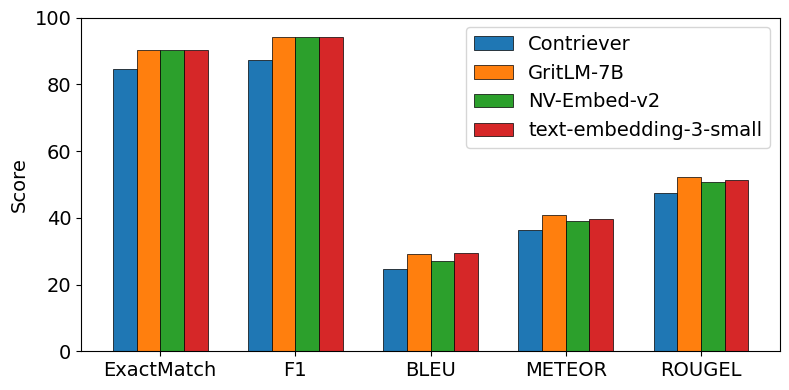

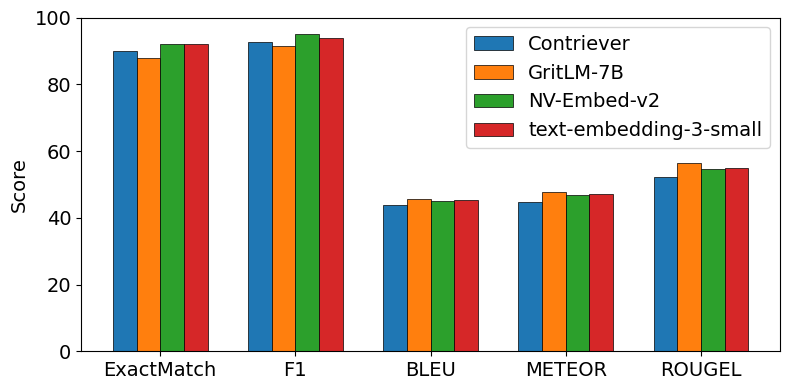

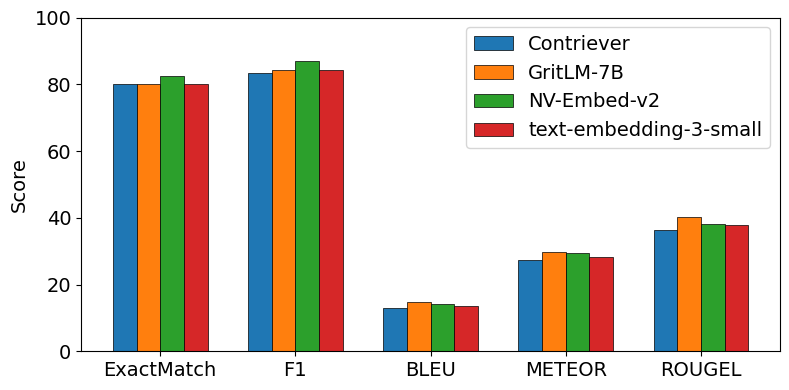

In [80]:
fontsize = 14
for major in majors:
    radar_results = []
    for postfix in postfixes:
        if not postfix  in ["bm25", "faiss"]:
            results = {
                "method": postfix.replace("hcmus_", "").replace("contriever", "Contriever"),
            }
            for kind_of_qa in kinds_of_qa: 
                dirpath = tmpl_dirpath.format(major=major, kind_of_qa=kind_of_qa, postfix=postfix)
                results_fpath = os.path.join(dirpath, "results.json")
                if kind_of_qa == "closed_end":
                    tmp_results = json.load(open(results_fpath, "r"))["closed_ended"]
                    tmp_results = {
                        k: v*100 for k, v in tmp_results.items()  # convert to percentage
                    }
                else:
                    tmp_results = json.load(open(results_fpath, "r"))["open_ended"]
                    tmp_results = {
                        k.upper(): float(v) for k, v in tmp_results.items()  # convert to percentage
                    }
                results.update(tmp_results)
            radar_results.append(results)
    df = pd.DataFrame(radar_results)
    df.set_index('method', inplace=True)

    # Transpose so metrics are x-axis
    df_T = df.transpose()

    n_metrics = len(df_T.index)
    n_methods = len(df_T.columns)
    bar_width = 0.175
    x = np.arange(n_metrics)

    fig, ax = plt.subplots(figsize=(8, 4))
    colors = plt.get_cmap('tab10').colors

    for i, method in enumerate(df_T.columns):
        ax.bar(x + i * bar_width, df_T[method], width=bar_width, label=method, color=colors[i % len(colors)], edgecolor='black', linewidth=0.5)  # Set edgecolor and linewidth for border
    ## add border to the bars

    ax.set_xticks(x + bar_width * (n_methods-1) / 2)
    ax.set_xticklabels(df_T.index, rotation=0, fontsize=fontsize)
    ax.set_ylabel('Score', fontsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)  # Set y-tick fontsize
    # ax.set_title('Comparison of Methods by Metric')
    ax.set_ylim(0, 100)  # Assuming scores are in percentage
    ax.legend(ncols=1, fontsize=fontsize)
    plt.tight_layout()
    plt.savefig(f"../results/{major}_qa_bar_chart.pdf", dpi=300, bbox_inches='tight')
    plt.show()

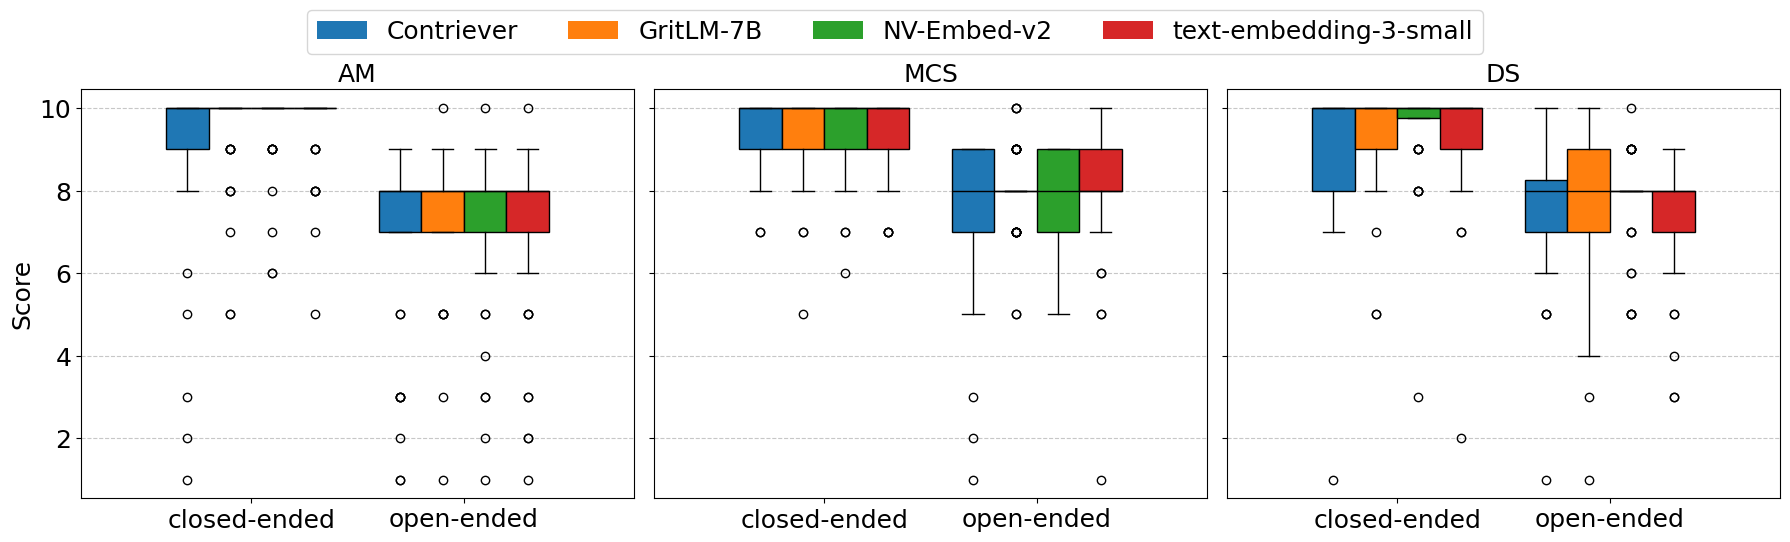

In [30]:
fontsize = 18
major_results_list = []
for major in majors:
    major_results = []
    for postfix in postfixes:
        if not postfix  in ["bm25", "faiss"]:
            results = {
                "method": postfix.replace("hcmus_", "").replace("contriever", "Contriever"),
            }
            for kind_of_qa in kinds_of_qa: 
                dirpath = tmpl_dirpath.format(major=major, kind_of_qa=kind_of_qa, postfix=postfix)
                results_fpath = os.path.join(dirpath, "results.json")
                gpt_judgement_scores = json.load(open(results_fpath, "r"))["gpt_judgement"]
                gpt_judgement_scores = [float(score) for score in gpt_judgement_scores]
                results.update(
                    {
                        f"{kind_of_qa}": gpt_judgement_scores
                    }
                )
            major_results.append(results)
    major_results_list.append(major_results)

# Prepare data for DataFrame for each major
dfs = []
for major_results in major_results_list:
    records = []
    for res in major_results:
        for qa_type in ['closed_end', 'opened_end']:
            for score in res[qa_type]:
                records.append({'method': res['method'], 'QA Type': qa_type, 'Score': score})
    dfs.append(pd.DataFrame(records))

# Plot grouped boxplot as subplots (3 columns, 1 row)
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
colors = plt.get_cmap('tab10').colors
width = 0.2

for idx, (ax, df, major) in enumerate(zip(axes, dfs, majors)):
    methods = df['method'].unique()
    for i, method in enumerate(methods):
        pos = [1 + i*width, 2 + i*width]
        data = [
            df[(df['method'] == method) & (df['QA Type'] == 'closed_end')]['Score'],
            df[(df['method'] == method) & (df['QA Type'] == 'opened_end')]['Score']
        ]
        bp = ax.boxplot(
            data,
            positions=pos,
            widths=width,
            patch_artist=True,
            boxprops=dict(facecolor=colors[i % len(colors)]),
            medianprops=dict(color='black')
        )
    ax.set_xticks([1 + width*(len(methods)-1)/2, 2 + width*(len(methods)-1)/2])
    ax.set_xticklabels(['closed-ended', 'open-ended'], fontsize=fontsize)
    ax.set_title(major, fontsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    if idx == 0:
        ax.set_ylabel('Score', fontsize=fontsize)
    # if idx == 2:
    #     ax.legend(
    #         [plt.Rectangle((0,0),1,1,facecolor=colors[i % len(colors)]) for i in range(len(methods))],
    #         methods,
    #         ncols=len(methods)//2,
    #         fontsize=fontsize-2,
    #         loc='upper left'
    #     )
# Create a shared legend outside the subplots
handles = [plt.Rectangle((0,0),1,1,facecolor=colors[i % len(methods)]) for i in range(len(methods))]
fig.legend(
    handles,
    methods,
    ncols=len(methods),
    fontsize=fontsize,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.1),
)
plt.tight_layout()
plt.savefig("../results/gpt4_judgement_boxplot.pdf", dpi=300, bbox_inches='tight')
plt.show()

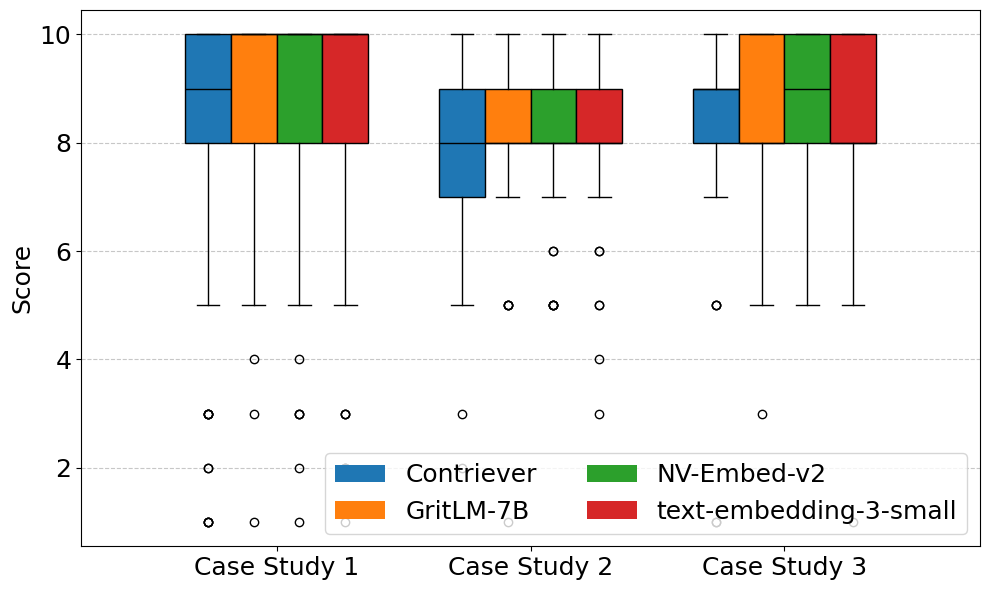

In [11]:
fontsize = 18
cstd_results_list = []
# major_results = []
for postfix in postfixes:
    if not postfix  in ["bm25", "faiss"]:
        results = {
            "method": postfix.replace("hcmus_", "").replace("contriever", "Contriever"),
            "case_study_1": [],
            "case_study_2": [],
            "case_study_3": [],
        }
        for major in majors:
            for kind_of_qa in kinds_of_qa: 
                open_end_qa_ds = pd.DataFrame(json.load(open(f"../data/rag_qa_test/{major}/{major}_{kind_of_qa}.json", "r")))
                case_studies = open_end_qa_ds[["case_std_id"]]
                dirpath = tmpl_dirpath.format(major=major, kind_of_qa=kind_of_qa, postfix=postfix)
                results_fpath = os.path.join(dirpath, "results.json")
                gpt_judgement_scores = json.load(open(results_fpath, "r"))["gpt_judgement"]
                gpt_judgement_scores = [float(score) for score in gpt_judgement_scores]
                for case_std in range(1, 4):
                    case_std_idx = case_studies[case_studies["case_std_id"] == case_std].index
                    case_std_scores = [gpt_judgement_scores[idx] for idx in case_std_idx]
                    results[f"case_study_{case_std}"].extend(case_std_scores)
        cstd_results_list.append(results)

# Convert cstd_results_list to long-form DataFrame
records = []
for d in cstd_results_list:
    for cs in ['case_study_1', 'case_study_2', 'case_study_3']:
        for score in d[cs]:
            records.append({'method': d['method'], 'case_study': cs, 'score': score})
df = pd.DataFrame(records)

# Prepare for grouped boxplot
fontsize = 18
methods = df['method'].unique()
case_studies = ['case_study_1', 'case_study_2', 'case_study_3']
colors = plt.get_cmap('tab10').colors
width = 0.18

fig, ax = plt.subplots(figsize=(10, 6))

# Calculate positions for each box
n_methods = len(methods)
positions = []
for i, cs in enumerate(case_studies):
    for j in range(n_methods):
        positions.append(i + j * width)

# Plot each box
for i, cs in enumerate(case_studies):
    for j, method in enumerate(methods):
        pos = i + j * width
        data = df[(df['case_study'] == cs) & (df['method'] == method)]['score']
        bp = ax.boxplot(
            data,
            positions=[pos],
            widths=width,
            patch_artist=True,
            boxprops=dict(facecolor=colors[j % len(colors)]),
            medianprops=dict(color='black')
        )

# Set x-ticks in the center of each group
group_centers = [i + width * (n_methods-1)/2 for i in range(len(case_studies))]
ax.set_xticks(group_centers)
ax.set_xticklabels(['Case Study 1', 'Case Study 2', 'Case Study 3'], fontsize=fontsize)
ax.set_ylabel('Score', fontsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
# ax.set_title('Case Study Scores by Method', fontsize=fontsize)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Legend
handles = [plt.Rectangle((0,0),1,1,facecolor=colors[i % len(colors)]) for i in range(n_methods)]
ax.legend(handles, methods, fontsize=fontsize, loc='lower right', ncol=2)
plt.tight_layout()
plt.savefig("../results/case_study_grouped_boxplot.pdf", dpi=300, bbox_inches='tight')
plt.show()
